# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [6]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [7]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

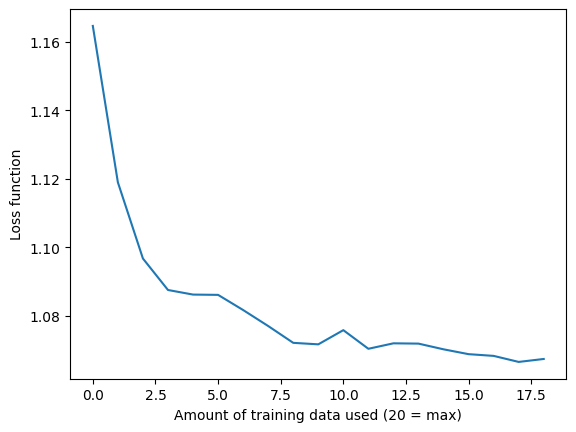

In [8]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [9]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

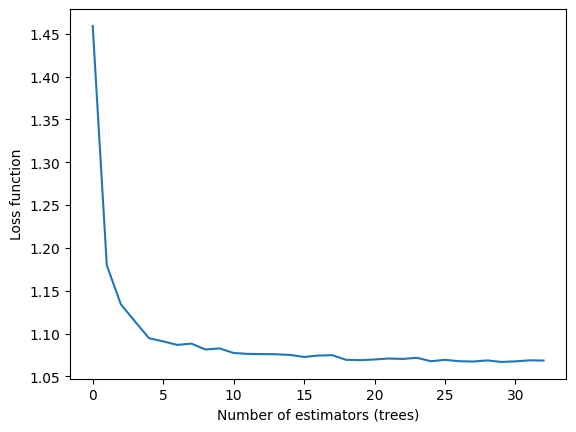

In [10]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

If we had to drop one of the plots, I would drop the number of estimator plot. While number of estimator plateaus completely after 10, training data plot shows some variance as it goes down to 17.5. Meaning we are capturing more information about what the regressor is doing to the data than the "estimators" plot.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

df = pd.read_csv("processed_insurance_claims.csv")

# Handle missing values (drop or fill NaN)
df_numerical = df.select_dtypes(include=[np.number]).dropna()  # Drop rows with NaN
X = df_numerical.drop(['fraud_reported'], axis=1)
y = df_numerical['fraud_reported']


scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_numerical)

X_0 = X

# For alpha = 10: Use selected features (top 10 most important)
basic_rf = RandomForestRegressor(random_state=42)
basic_rf.fit(X, y)
importances = basic_rf.feature_importances_
feature_indices = np.argsort(importances)[::-1]
top_10_features = X.columns[feature_indices[:10]]
X_10 = X[top_10_features]

# Split datasets into train/test
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y, test_size=0.2, random_state=42)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y, test_size=0.2, random_state=42)

In [12]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Train Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2

# Evaluate for alpha = 0
mse_0, r2_0 = train_and_evaluate(X_train_0, X_test_0, y_train_0, y_test_0)

# Evaluate for alpha = 10
mse_10, r2_10 = train_and_evaluate(X_train_10, X_test_10, y_train_10, y_test_10)

print(f"Alpha = 0: MSE={mse_0:.4f}, R²={r2_0:.4f}")
print(f"Alpha = 10: MSE={mse_10:.4f}, R²={r2_10:.4f}")

Alpha = 0: MSE=0.2045, R²=-0.0257
Alpha = 10: MSE=0.2070, R²=-0.0383


In [13]:
def perform_cv(X, y, cv=5):
    rf = RandomForestRegressor(random_state=42)
    mse_scores = -cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
    return mse_scores.mean(), r2_scores.mean()

# CV for both datasets
cv_mse_0, cv_r2_0 = perform_cv(X_0, y)
cv_mse_10, cv_r2_10 = perform_cv(X_10, y)

print(f"CV - Alpha = 0: MSE={cv_mse_0:.4f}, R²={cv_r2_0:.4f}")
print(f"CV - Alpha = 10: MSE={cv_mse_10:.4f}, R²={cv_r2_10:.4f}")

CV - Alpha = 0: MSE=0.1965, R²=-0.0628
CV - Alpha = 10: MSE=0.1977, R²=-0.0684


In [14]:
def tune_hyperparams(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_, -grid_search.best_score_, grid_search.best_estimator_

# Tune for alpha = 0
print("\nHyperparameter Tuning (Alpha = 0):")
best_params_0, best_score_0, best_rf_0 = tune_hyperparams(X_train_0, y_train_0)
print("Best parameters:", best_params_0)
print("Best MSE:", best_score_0)

# Tune for alpha = 10
print("\nHyperparameter Tuning (Alpha = 10):")
best_params_10, best_score_10, best_rf_10 = tune_hyperparams(X_train_10, y_train_10)
print("Best parameters:", best_params_10)
print("Best MSE:", best_score_10)


Hyperparameter Tuning (Alpha = 0):
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE: 0.18526178067110127

Hyperparameter Tuning (Alpha = 10):
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best MSE: 0.18842765378439089


In [15]:
y_pred_best_0 = best_rf_0.predict(X_test_0)
best_mse_0 = mean_squared_error(y_test_0, y_pred_best_0)
best_r2_0 = r2_score(y_test_0, y_pred_best_0)

y_pred_best_10 = best_rf_10.predict(X_test_10)
best_mse_10 = mean_squared_error(y_test_10, y_pred_best_10)
best_r2_10 = r2_score(y_test_10, y_pred_best_10)

print(f"\nBest Model (Alpha = 0): MSE={best_mse_0:.4f}, R²={best_r2_0:.4f}")
print(f"Best Model (Alpha = 10): MSE={best_mse_10:.4f}, R²={best_r2_10:.4f}")


Best Model (Alpha = 0): MSE=0.2011, R²=-0.0088
Best Model (Alpha = 10): MSE=0.1971, R²=0.0114


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.